In [ ]:
import numpy as np 
import pandas as pd 
import shutil
import os
import zipfile
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
import copy
import tqdm
from PIL import Image

import albumentations
import torchvision.datasets as dataset
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import natsort
%matplotlib inline
import time

In [ ]:
!nvidia-smi

Sun Aug 30 14:55:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    34W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
base_dir = '/content/gdrive/My Drive/corpus_kaggle'

img_size=224

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
sample_submission = pd.read_csv(base_dir + "/sample_submission.csv")
#transforms_list=[transforms.CenterCrop(150),transforms.RandomCrop(150)]#,transforms.ColorJitter(brightness=0.8, contrast=0.5, saturation=0.5, hue=0.2)]

data_transforms = transforms.Compose([
    #transforms.Resize((img_size, img_size)),                                  
    #transforms.ToPILImage(),
    #transforms.RandomApply(transforms_list, p=0.5),
    transforms.RandomHorizontalFlip(0.5),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.7675,0.7675,0.7675),std=(0.2968,0.2968,0.2968))
    transforms.Normalize(mean=(0.774,0.772,0.763),std=(0.296,0.291,0.308))
    ])

data_transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    #transforms.Normalize((0.7673,0.7673,0.7673),(0.2911,0.2911,0.2911))
    transforms.Normalize((0.76998,0.7697,0.74801),(0.308,0.2987,0.3193))
    ])


In [ ]:
test_list = os.listdir(test_dir)

In [ ]:
len(test_list)

1753

In [ ]:
train_dataset = dataset.ImageFolder(root = train_dir,
                                     transform = data_transforms)


In [ ]:
train_dataset.class_to_idx

{'bar_chart': 0,
 'diagram': 1,
 'flow_chart': 2,
 'graph': 3,
 'growth_chart': 4,
 'just_image': 5,
 'pie_chart': 6,
 'table': 7}

In [ ]:
def train_val_dataset(dataset, val_split=0.08):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

print(len(train_dataset))
datasets = train_val_dataset(train_dataset)
print(len(datasets['train']))
print(len(datasets['val']))
# The original dataset is available in the Subset class

13336
12269
1067


In [ ]:
class TestDataset(Dataset):
    
    def __init__(self, path, img_list, transform=None, mode='test'):
        self.path = path
        self.img_list = img_list
        self.transform=transform
        self.mode = mode
        
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self, idx):
        
        image_name = self.img_list[idx]
        if  image_name.split(".")[-1].lower() == "gif":
            gif = cv2.VideoCapture(os.path.join(self.path, image_name))
            _, image = gif.read()
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = cv2.imread(os.path.join(self.path, image_name))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        if self.transform:
            image = self.transform(image)
            #image = augmented["image"]
      
        return image,image_name

In [ ]:
#batch_s
train_load = torch.utils.data.DataLoader(datasets['train'],batch_size=36,shuffle=True)
val_load = torch.utils.data.DataLoader(datasets['val'],batch_size=36,shuffle=True)


In [ ]:
testset = TestDataset(test_dir, test_list,  transform=data_transforms_test, mode="test")
test_load = torch.utils.data.DataLoader(testset,batch_size=36,num_workers = 4)


In [ ]:
len(test_load)

49

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


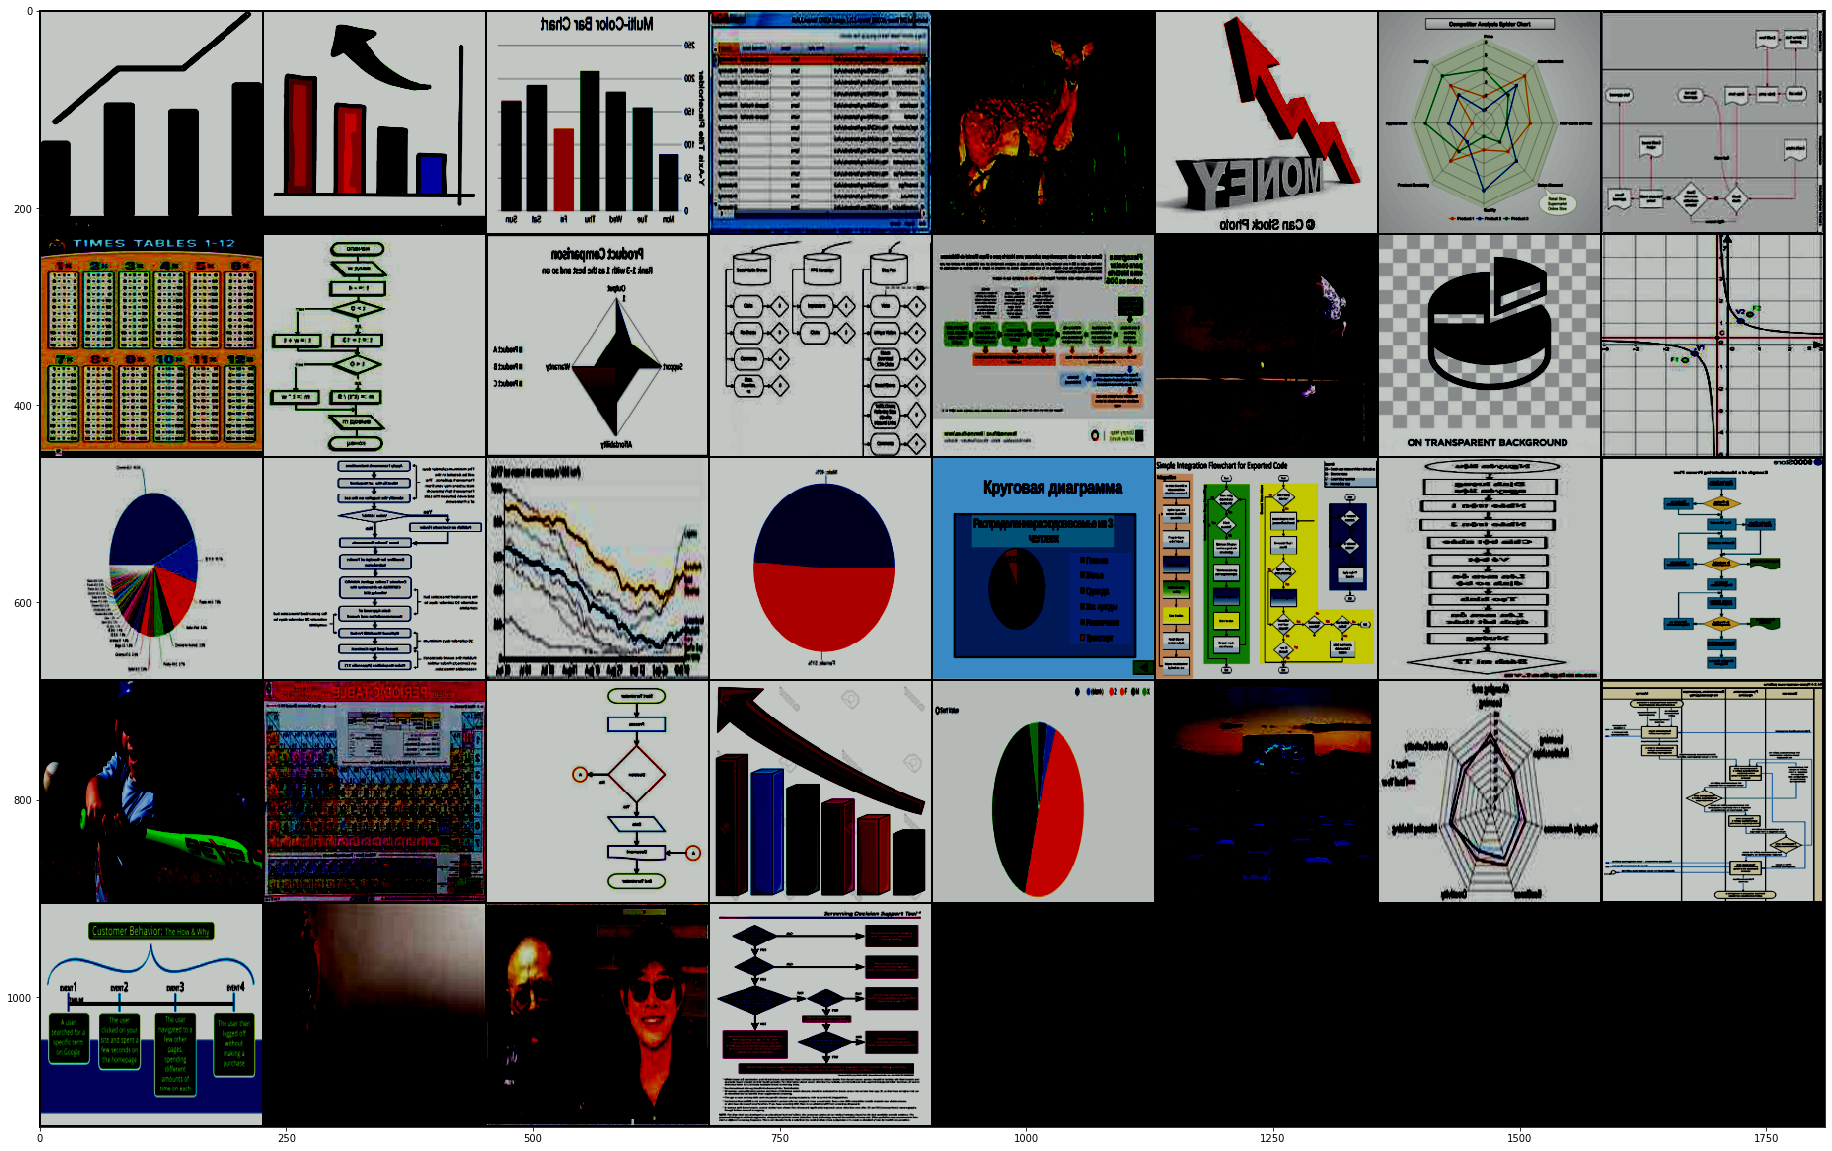

In [ ]:
samples,files = next(iter(train_load))
plt.figure(figsize=(32,48))
grid_imgs = torchvision.utils.make_grid(samples)
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)), interpolation='nearest')


In [ ]:
samples.shape

torch.Size([64, 3, 224, 224])

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=0)

In [ ]:
from torchsummary import summary

In [ ]:
model = torchvision.models.resnet152(pretrained=False,progress=True)

In [ ]:
#model.load_state_dict(torch.load('/content/gdrive/My Drive/corpus_kaggle/models/model_2_googlenet(SGD0.1).pt'))
#model.eval()
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#for param in model.parameters():
    #param.requires_grad = False
'''
in_features = model.fc.in_features
model.relu=nn.LeakyReLU()
model.layer1[0].relu=nn.LeakyReLU()
model.layer1[1].relu=nn.LeakyReLU()
model.layer1[2].relu=nn.LeakyReLU()
model.layer2[0].relu=nn.LeakyReLU()
model.layer2[1].relu=nn.LeakyReLU()
model.layer2[2].relu=nn.LeakyReLU()
model.layer2[3].relu=nn.LeakyReLU()
model.layer3[0].relu=nn.LeakyReLU()
model.layer3[1].relu=nn.LeakyReLU()
model.layer3[2].relu=nn.LeakyReLU()
model.layer3[3].relu=nn.LeakyReLU()
model.layer3[4].relu=nn.LeakyReLU()
model.layer3[5].relu=nn.LeakyReLU()
model.layer4[0].relu=nn.LeakyReLU()
model.layer4[1].relu=nn.LeakyReLU()
model.layer4[2].relu=nn.LeakyReLU()

#model.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
#model.classifier[6] = nn.Linear(4096, 8)'''
in_features = model.fc.in_features
model.fc=nn.Linear(in_features, 8)

In [ ]:
'''
model.features[1]=nn.LeakyReLU()
model.features[3]=nn.LeakyReLU()
model.features[6]=nn.LeakyReLU()
model.features[8]=nn.LeakyReLU()
model.features[11]=nn.LeakyReLU()
model.features[13]=nn.LeakyReLU()
model.features[15]=nn.LeakyReLU()
model.features[17]=nn.LeakyReLU()
model.features[20]=nn.LeakyReLU()
model.features[22]=nn.LeakyReLU()
model.features[24]=nn.LeakyReLU()
model.features[26]=nn.LeakyReLU()
model.features[29]=nn.LeakyReLU()
model.features[31]=nn.LeakyReLU()
model.features[33]=nn.LeakyReLU()
model.features[35]=nn.LeakyReLU()


model.layer1[0].relu=nn.LeakyReLU()
model.layer1[1].relu=nn.LeakyReLU()
model.layer1[2].relu=nn.LeakyReLU()
model.layer2[0].relu=nn.LeakyReLU()
model.layer2[1].relu=nn.LeakyReLU()
model.layer2[2].relu=nn.LeakyReLU()
model.layer2[3].relu=nn.LeakyReLU()
model.layer3[0].relu=nn.LeakyReLU()
model.layer3[1].relu=nn.LeakyReLU()
model.layer3[2].relu=nn.LeakyReLU()
model.layer3[3].relu=nn.LeakyReLU()
model.layer3[4].relu=nn.LeakyReLU()
model.layer3[5].relu=nn.LeakyReLU()
model.layer4[0].relu=nn.LeakyReLU()
model.layer4[1].relu=nn.LeakyReLU()
model.layer4[2].relu=nn.LeakyReLU()

model.classifier[1] = nn.LeakyReLU()
model.classifier[4] = nn.LeakyReLU()
'''
model.classifier[6] = nn.Linear(4096, 8)


In [ ]:
def train_model(model_conv, train_loader, valid_loader, criterion, optimizer, sheduler, n_epochs):
    model_conv.to(device)
    valid_loss_min = np.Inf
    patience = 10
    # сколько эпох ждем до отключения
    p = 0
    # иначе останавливаем обучение
    stop = False

    # количество эпох
    for epoch in range(1, n_epochs+1):
          print(time.ctime(), 'Epoch:', epoch)
          b_i=0
          train_loss = []

          for batch_i, (data, target) in enumerate(train_loader):
              b_i+=1
              data, target = data.to(device), target.to(device)
              optimizer.zero_grad()
              output = model_conv(data)
              loss = criterion(output, target)
              train_loss.append(loss.item())
              loss.backward()
              optimizer.step()
              if b_i % 10 == 0: 
                  print(b_i)
      # запускаем валидацию
          model_conv.eval()
          val_loss = []
          for batch_i, (data, target) in enumerate(valid_loader):
              data, target = data.to(device), target.to(device)
              output = model_conv(data)
              loss = criterion(output, target)
              val_loss.append(loss.item()) 

          print(f"Epoch {epoch}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}, lr: {optimizer.param_groups[0]['lr']}")

          valid_loss = np.mean(val_loss)
          sheduler.step(valid_loss)
          if valid_loss <= valid_loss_min:
              print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,
              valid_loss))
              torch.save(model_conv.state_dict(), '/content/gdrive/My Drive/corpus_kaggle/models/model_1_resnet152(SGD_0.1).pt')
              
              valid_loss_min = valid_loss
              p = 0

          # проверяем как дела на валидации
          if valid_loss > valid_loss_min:
              p += 1
              
              print(f'{p} epochs of increasing val loss')
              if p > patience:
                  print('Stopping training')
                  stop = True
                  break        

          if stop:
              break

        
    return model_conv, train_loss, val_loss

In [ ]:
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(),lr=0.01)#,momentum=0.9,nesterov=True,lr=0.1)
optimizer = torch.optim.SGD(model.parameters(),lr=0.1,momentum=0.9,nesterov=True)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, verbose=True)


In [ ]:
model_resnet, train_loss, val_loss = train_model(model, train_load, val_load, criterion, 
                              optimizer, scheduler, n_epochs=150)

Sun Aug 30 14:56:34 2020 Epoch: 1
10
20


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


30
40
50
60
70


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
Epoch 1, train loss: 2.4426, valid loss: 1.5489, lr: 0.1
Validation loss decreased (inf --> 1.548916).  Saving model ...
Sun Aug 30 15:03:24 2020 Epoch: 2
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
Epoch 2, train loss: 1.9506, valid loss: 1.5235, lr: 0.1
Validation loss decreased (1.548916 --> 1.523513).  Saving model ...
Sun Aug 30 15:09:55 2020 Epoch: 3
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
Epoch 3, train loss: 1.4722, valid loss: 1.3870, lr: 0.1
Validation loss decreased (1.523513 --> 1.386993).  Saving model ...
Sun Aug 30 15:16:29 2020 Epoch: 4
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
Epoch 4, train loss: nan, valid loss: 

KeyboardInterrupt: ignored

In [ ]:
#torch.save(model.state_dict(),'/content/gdrive/My Drive/corpus_kaggle/models/model_1_(bad_loss)_inceptionv3(SGD0.1)_ROP.pt')

In [ ]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/corpus_kaggle/models/model_1_inception_v3(SGD_0.1).pt'))

<All keys matched successfully>

In [ ]:
import torch.nn.functional as F

In [ ]:
model.to(device)
model.eval()
pred_list = []
names_list = []
for images, image_names in test_load:
    with torch.no_grad():
        images = images.to(device)
        output = model(images)
        pred = F.softmax(output)
        pred = torch.argmax(pred, dim=1).cpu().numpy()
        pred_list += [p.item() for p in pred]
        names_list += [name for name in image_names]


sample_submission.image_name = names_list
sample_submission.label = pred_list
sample_submission['label']=sample_submission['label'].map({0: '1', 1: '2',2:'3',3:'4',4:'5',5:'0',6:'6',7:'7'})
sample_submission.to_csv('submission1_inception3_net.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
correct=0
model.to(device)
model.eval()
with torch.no_grad():
  for data, target in val_load:
    data = data.to(device=device)
    target = target.to(device=device)
    outputs = model(data)
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == target).sum().item()


acc = correct / len(datasets['val'])
print(f'Accuracy on test set: {acc}')

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Accuracy on test set: 0.8940955951265229
